# 🎬 Simple Hybrid Movie Recommender

**Same architecture as the advanced version, but beginner-friendly!**

## Architecture Overview:
1. **Content-Based Filtering** - Recommends movies with similar descriptions
2. **Collaborative Filtering** - Recommends based on what similar users liked
3. **Neural Meta-Learner** - Combines both approaches intelligently

---

In [1]:
# ========================================
# STEP 1: Install & Import Libraries
# ========================================
!pip install -q pandas numpy scikit-learn implicit sentence-transformers torch scipy

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import implicit
from scipy.sparse import csr_matrix
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

print('✅ Libraries loaded!')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 6.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
✅ Libraries loaded!


In [3]:
# %%
# 02 - Kaggle credentials upload (Colab-specific)
# Run this cell and upload kaggle.json when prompted, ONLY if you want the notebook to download the dataset.
# If you already uploaded the dataset files into /content/data, skip this cell.
from google.colab import files
print('If you already uploaded dataset files to /content/data, skip this upload. Otherwise upload kaggle.json now.')
uploaded = files.upload() # choose kaggle.json

If you already uploaded dataset files to /content/data, skip this upload. Otherwise upload kaggle.json now.


Saving movies_metadata.csv to movies_metadata.csv


In [4]:
# %%
# 02 - Kaggle credentials upload (Colab-specific)
# Run this cell and upload kaggle.json when prompted, ONLY if you want the notebook to download the dataset.
# If you already uploaded the dataset files into /content/data, skip this cell.
from google.colab import files
print('If you already uploaded dataset files to /content/data, skip this upload. Otherwise upload kaggle.json now.')
uploaded = files.upload() # choose kaggle.json

If you already uploaded dataset files to /content/data, skip this upload. Otherwise upload kaggle.json now.


Saving ratings_small.csv to ratings_small.csv


In [27]:
# ========================================
# STEP 2: Load Data
# ========================================
# Upload your CSV files or use sample data

# Load movies metadata
# Using the (1).csv files as they contain the data uploaded by the user.
movies = pd.read_csv('movies_metadata.csv', low_memory=False)
movies = movies[['id', 'title', 'overview', 'genres', 'vote_average', 'vote_count']]
movies = movies.dropna(subset=['overview', 'title'])
movies['id'] = pd.to_numeric(movies['id'], errors='coerce')
movies = movies.dropna(subset=['id'])
movies['id'] = movies['id'].astype(int)

# Load ratings
ratings = pd.read_csv('ratings_small.csv')
ratings = ratings[['userId', 'movieId', 'rating']]

# Keep only movies that have ratings
common_movies = set(movies['id']) & set(ratings['movieId'])
movies = movies[movies['id'].isin(common_movies)].reset_index(drop=True)
ratings = ratings[ratings['movieId'].isin(common_movies)]

print(f'✅ Loaded {len(movies)} movies and {len(ratings)} ratings')
print(f'   Users: {ratings["userId"].nunique()}')
movies.head()

✅ Loaded 2810 movies and 44852 ratings
   Users: 671


,id,title,overview,genres,vote_average,vote_count
0,949,Heat,"Obsessive master thief, Neil McCauley leads a ...","[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",7.7,1886.0
1,710,GoldenEye,James Bond must unmask the mysterious head of ...,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",6.6,1194.0
2,1408,Cutthroat Island,"Morgan Adams and her slave, William Shaw, are ...","[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",5.7,137.0
3,524,Casino,The life of the gambling paradise – Las Vegas ...,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",7.8,1343.0
4,4584,Sense and Sensibility,"Rich Mr. Dashwood dies, leaving his second wif...","[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",7.2,364.0


In [6]:
# %%
# 02 - Kaggle credentials upload (Colab-specific)
# Run this cell and upload kaggle.json when prompted, ONLY if you want the notebook to download the dataset.
# If you already uploaded the dataset files into /content/data, skip this cell.
from google.colab import files
print('If you already uploaded dataset files to /content/data, skip this upload. Otherwise upload kaggle.json now.')
uploaded = files.upload() # choose kaggle.json

If you already uploaded dataset files to /content/data, skip this upload. Otherwise upload kaggle.json now.


Saving links_small.csv to links_small.csv


In [28]:
# Load links and map IDs
links = pd.read_csv('links_small.csv')

# Merge to add movieId (MovieLens ID) to movies dataframe
# movies['id'] is TMDB ID, we need to map it to MovieLens movieId
merged_movies = movies.merge(
    links[['movieId', 'tmdbId']],
    left_on='id',
    right_on='tmdbId',
    how='left'
)

# Handle potential duplicate column names after merge if movieId already existed.
# We want the 'movieId' from the right side of the merge (links data) if suffixes were added,
# or the single 'movieId' column if no suffixes were added (first merge).
if 'movieId_y' in merged_movies.columns:
    # If suffixes were added, take the one from the right (links data) and rename it
    merged_movies['movieId'] = merged_movies['movieId_y']
    # Drop the suffixed columns that are no longer needed
    merged_movies = merged_movies.drop(columns=['movieId_x', 'tmdbId_x', 'movieId_y', 'tmdbId_y'], errors='ignore')
elif 'movieId' in merged_movies.columns and 'tmdbId' in merged_movies.columns:
    # If no suffixes, it means 'movieId' was newly added directly, and 'tmdbId' is also from the merge.
    # This case is when it's the first time the merge truly adds 'movieId' and 'tmdbId'. No renaming needed.
    pass # 'movieId' column is already correctly named
# If 'movieId' is still missing for some reason, the next dropna will raise an error.

movies = merged_movies # Update the global movies DataFrame

# Drop rows where we couldn't find a mapping
movies = movies.dropna(subset=['movieId'])
movies['movieId'] = movies['movieId'].astype(int)

print(f'✅ Mapped {len(movies)} movies to MovieLens IDs')

✅ Mapped 1547 movies to MovieLens IDs


---
## 🔵 PART 1: Content-Based Filtering
Uses movie descriptions to find similar movies

In [29]:
# ========================================
# STEP 3: Create Movie Embeddings
# ========================================
# Convert movie descriptions into numerical vectors

print('Loading sentence transformer model...')
encoder = SentenceTransformer('all-MiniLM-L6-v2')

print('Creating embeddings for movie descriptions...')
movie_texts = movies['overview'].fillna('').tolist()
movie_embeddings = encoder.encode(movie_texts, show_progress_bar=True)

print(f'✅ Created embeddings: shape = {movie_embeddings.shape}')
print(f'   Each movie is now a vector of {movie_embeddings.shape[1]} numbers')

Loading sentence transformer model...
Creating embeddings for movie descriptions...


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

✅ Created embeddings: shape = (1547, 384)
   Each movie is now a vector of 384 numbers


In [30]:
# Filter movies to only those that exist in ratings
ratings_movie_ids = set(ratings['movieId'].unique())
movies = movies[movies['movieId'].isin(ratings_movie_ids)]
# IMPORTANT: Filter ratings to only include movies present in the now-filtered movies DataFrame
ratings = ratings[ratings['movieId'].isin(movies['movieId'])]

print(f'✅ Filtered to {len(movies)} movies that have ratings')

# IMPORTANT: Rebuild movie_id_to_idx mapping after filtering
movie_id_to_idx = {mid: idx for idx, mid in enumerate(movies['id'])}
# In the filtering cell, add this after movie_id_to_idx:
movies = movies.reset_index(drop=True)  # Reset index after filtering
movie_id_to_idx = {mid: idx for idx, mid in enumerate(movies['id'])}
movieId_to_idx = {mid: idx for idx, mid in enumerate(movies['movieId'])}


# Rebuild movie embeddings for filtered movies
print('Rebuilding embeddings for filtered movies...')
movie_embeddings = encoder.encode(
    movies['overview'].fillna('').tolist(),
    show_progress_bar=True
)
print(f'✅ Embeddings shape: {movie_embeddings.shape}')

✅ Filtered to 576 movies that have ratings
Rebuilding embeddings for filtered movies...


Batches:   0%|          | 0/18 [00:00<?, ?it/s]

✅ Embeddings shape: (576, 384)


In [31]:
# ========================================
# STEP 4: Content-Based Similarity
# ========================================

def get_content_similar(movie_idx, top_k=10):
    """
    Find movies with similar descriptions.

    Args:
        movie_idx: Index of the movie in our dataframe
        top_k: Number of similar movies to return

    Returns:
        List of (movie_index, similarity_score) tuples
    """
    # Get the embedding for this movie
    movie_vector = movie_embeddings[movie_idx].reshape(1, -1)

    # Calculate similarity with all other movies
    similarities = cosine_similarity(movie_vector, movie_embeddings)[0]

    # Get top similar movies (excluding itself)
    similar_indices = similarities.argsort()[::-1][1:top_k+1]

    return [(idx, similarities[idx]) for idx in similar_indices]

# Test it!
test_movie = 'Heat'

# Check if the movie exists
if test_movie not in movies['title'].values:
    print(f'Error: Movie "{test_movie}" not found in the dataset. Please choose an existing movie.')
else:
    test_idx = movies[movies['title'] == test_movie].index[0]
    similar = get_content_similar(test_idx, top_k=5)

    print(f'\n🎬 Movies similar to "{test_movie}":')
    for idx, score in similar:
        print(f'   {movies.iloc[idx]["title"]} (similarity: {score:.3f})')



🎬 Movies similar to "Heat":
   Die Hard: With a Vengeance (similarity: 0.475)
   Vertigo (similarity: 0.458)
   Sherlock, Jr. (similarity: 0.416)
   Point Break (similarity: 0.415)
   Kiss Kiss Bang Bang (similarity: 0.414)


---
## 🟢 PART 2: Collaborative Filtering
Uses user ratings to find patterns ("users who liked X also liked Y")

In [32]:
# ========================================
# STEP 5: Train Collaborative Filter (ALS)
# ========================================
# Using 'implicit' library instead of Surprise (NumPy 2.0 compatible)

print('Training collaborative filtering model (ALS)...')

# Create category mappings for users and movies
user_cat = ratings['userId'].astype('category')
movie_cat = ratings['movieId'].astype('category')

# Store mappings for later use
user_to_idx = {uid: idx for idx, uid in enumerate(user_cat.cat.categories)}
movie_to_idx = {mid: idx for idx, mid in enumerate(movie_cat.cat.categories)}
# Add this line after: movie_id_to_idx = {mid: idx for idx, mid in enumerate(movies['id'])}
movieId_to_idx = {row['movieId']: idx for idx, (_, row) in enumerate(movies.iterrows())}
print(f'✅ Created movieId_to_idx with {len(movieId_to_idx)} entries')

idx_to_movie = {idx: mid for mid, idx in movie_to_idx.items()}

# Build sparse user-item matrix (users x movies)
# implicit expects item-user matrix, so we transpose later
user_item_matrix = csr_matrix(
    (ratings['rating'], (user_cat.cat.codes, movie_cat.cat.codes))
)    #converting ratings into implicit feedback!

print(f'   Matrix shape: {user_item_matrix.shape} (users x movies)')

# Train ALS model (Alternating Least Squares - similar to SVD)
als_model = implicit.als.AlternatingLeastSquares(
    factors=100,
    iterations=30,
    regularization=0.05,
    random_state=42
)

# implicit expects item-user matrix (transpose of user-item)
als_model.fit(user_item_matrix.T)

print('✅ Collaborative filtering model trained!')
print(f'   User factors shape: {als_model.user_factors.shape}')
print(f'   Item factors shape: {als_model.item_factors.shape}')

def predict_rating(user_id, movie_id):
    """
    Predict how much a user would rate a movie.
    """
    # Get indices
    user_idx = user_to_idx.get(user_id)
    movie_idx = movie_to_idx.get(movie_id)

    if user_idx is None or movie_idx is None:
        return 2.5  # Default rating for unknown user/movie

    # Add bounds check for the ALS model matrices
    if user_idx >= als_model.user_factors.shape[0] or movie_idx >= als_model.item_factors.shape[0]:
        return 2.5  # Default rating if index is out of bounds

    # Get factors
    user_factors = als_model.user_factors[user_idx]
    item_factors = als_model.item_factors[movie_idx]

    # Convert to numpy arrays if they are implicit.gpu._cuda.Matrix
    if hasattr(user_factors, 'to_numpy'):
        user_factors = user_factors.to_numpy().flatten()
    else:
        user_factors = user_factors.flatten()

    if hasattr(item_factors, 'to_numpy'):
        item_factors = item_factors.to_numpy().flatten()
    else:
        item_factors = item_factors.flatten()

    # Dot product of latent factors gives predicted score
    score = np.dot(user_factors, item_factors) #Higher score → stronger preference .Used for ranking, not rating accuracy

    # Clip to rating scale (0.5 to 5.0)
    return np.clip(score, 0.5, 5.0)


Training collaborative filtering model (ALS)...
✅ Created movieId_to_idx with 575 entries
   Matrix shape: (670, 575) (users x movies)


  0%|          | 0/30 [00:00<?, ?it/s]

✅ Collaborative filtering model trained!
   User factors shape: (575, 100)
   Item factors shape: (670, 100)


In [33]:
# Test collaborative filtering
test_user = 1
test_movie_id = movies.iloc[0]['id']

predicted = predict_rating(test_user, test_movie_id)
print(f'Predicted rating for User {test_user} on "{movies.iloc[0]["title"]}": {predicted:.2f}/5.0')

Predicted rating for User 1 on "Heat": 0.50/5.0


---
## 🟣 PART 3: Neural Meta-Learner
A small neural network that learns to combine content + collaborative signals

In [34]:
# ========================================
# STEP 6: Prepare Training Data for Meta-Learner
# ========================================

# Create mappings for quick lookup
tmdb_id_to_df_idx = {mid: idx for idx, mid in enumerate(movies['id'])}
movielens_id_to_df_idx = {mlid: idx for idx, mlid in enumerate(movies['movieId'])}

# Pre-compute user profiles (average of movies they liked)
print('Building user profiles...')
user_profiles = {}
for user_id in tqdm(ratings['userId'].unique()):
    user_ratings = ratings[ratings['userId'] == user_id]
    liked = user_ratings[user_ratings['rating'] >= 4.0]['movieId'].tolist()
    if liked:
        # Correctly map MovieLens IDs from 'liked' list to DataFrame indices for movie_embeddings
        indices = [movieId_to_idx[m] for m in liked if m in movieId_to_idx]
        if indices:
            user_profiles[user_id] = movie_embeddings[indices].mean(axis=0)

# Parse genres from movies
import ast
def parse_genres(genres_str):
    try:
        genres = ast.literal_eval(genres_str)
        return [g['name'] for g in genres]
    except:
        return []

movies['genre_list'] = movies['genres'].apply(parse_genres)
all_genres = set(g for genres in movies['genre_list'] for g in genres)
print(f'Found {len(all_genres)} unique genres')

# Build user genre preferences
user_genre_prefs = {}
for user_id in ratings['userId'].unique():
    user_ratings = ratings[ratings['userId'] == user_id]
    liked_movies = user_ratings[user_ratings['rating'] >= 4.0]['movieId'].tolist()
    genre_counts = {}
    for mid in liked_movies:
        movie_row = movies[movies['id'] == mid] # mid here is MovieLens ID, but movies['id'] is TMDB ID
        # Need to find movie row by MovieLens ID
        movie_row = movies[movies['movieId'] == mid]
        if len(movie_row) > 0:
            for g in movie_row.iloc[0]['genre_list']:
                genre_counts[g] = genre_counts.get(g, 0) + 1
    user_genre_prefs[user_id] = genre_counts

def compute_features(user_id, movie_id):
    """
    Compute 8 features for the meta-learner.

    Features:
    1. CF score - Collaborative filtering prediction
    2. Popularity - How many people rated this movie (log scaled)
    3. Avg rating - Average rating of the movie
    4. Content similarity - How similar to user's liked movies
    5. Genre overlap - How many genres match user preferences
    6. User activity - How many movies user has rated
    7. Rating variance - How consistent is this movie's ratings
    8. Recency bias - Newer movies get slight boost
    """
    features = []

    # Feature 1: Collaborative filtering score
    # Need to pass MovieLens ID to predict_rating
    movie_row_df = movies[movies['id'] == movie_id] # movie_id passed here is TMDB ID
    if len(movie_row_df) == 0:
        # If TMDB ID not found, return default features
        return [0.5] + [0.5]*7 # Return 8 features
    current_movie_movielens_id = movie_row_df.iloc[0]['movieId']
    cf_score = predict_rating(user_id, current_movie_movielens_id) / 5.0
    features.append(cf_score)

    # Get movie data
    movie_row = movies[movies['id'] == movie_id]
    movie_idx = tmdb_id_to_df_idx.get(movie_id)

    if len(movie_row) > 0 and movie_idx is not None:
        row = movie_row.iloc[0]

        # Feature 2: Popularity (log scaled)
        popularity = np.log1p(row['vote_count']) / 15
        features.append(min(popularity, 1.0))

        # Feature 3: Average rating
        avg_rating = row['vote_average'] / 10
        features.append(avg_rating)

        # Feature 4: Content similarity to user profile
        if user_id in user_profiles:
            content_sim = cosine_similarity(
                movie_embeddings[movie_idx].reshape(1, -1),
                user_profiles[user_id].reshape(1, -1)
            )[0][0]
        else:
            content_sim = 0.5
        features.append(content_sim)

        # Feature 5: Genre overlap with user preferences
        movie_genres = set(row['genre_list'])
        user_prefs = user_genre_prefs.get(user_id, {})
        if user_prefs and movie_genres:
            overlap = sum(user_prefs.get(g, 0) for g in movie_genres)
            genre_score = min(overlap / 10, 1.0)
        else:
            genre_score = 0.5
        features.append(genre_score)

        # Feature 6: User activity level
        user_count = len(ratings[ratings['userId'] == user_id])
        user_activity = min(np.log1p(user_count) / 5, 1.0)
        features.append(user_activity)

        # Feature 7: Rating consistency (inverse of variance)
        movie_ratings = ratings[ratings['movieId'] == current_movie_movielens_id]['rating'] # Use MovieLens ID here
        if len(movie_ratings) > 1:
            variance = movie_ratings.var()
            consistency = 1 / (1 + variance)
        else:
            consistency = 0.5
        features.append(consistency)

        # Feature 8: Vote count ratio (quality signal)
        vote_ratio = row['vote_count'] / (row['vote_count'] + 100)  # Bayesian smoothing
        features.append(vote_ratio)
    else:
        # Default values if movie not found (excluding the CF score which is already handled)
        features.extend([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]) # Already has cf_score

    return features

FEATURE_NAMES = ['CF Score', 'Popularity', 'Avg Rating', 'Content Sim',
                 'Genre Overlap', 'User Activity', 'Rating Consistency', 'Vote Ratio']
print(f'\n✅ Using {len(FEATURE_NAMES)} features: {FEATURE_NAMES}')

print('Creating training data for meta-learner...')

# Sample some user-movie pairs for training
sample_ratings = ratings.sample(n=min(50000, len(ratings)), random_state=SEED)

X = []  # Features
y = []  # Labels (actual ratings)

for _, row in tqdm(sample_ratings.iterrows(), total=len(sample_ratings)):
    # Pass TMDB ID to compute_features, which expects it
    tmdb_movie_id = movies[movies['movieId'] == row['movieId']]['id'].iloc[0] if row['movieId'] in movies['movieId'].values else None
    if tmdb_movie_id is not None:
        features = compute_features(row['userId'], tmdb_movie_id)
        X.append(features)
        y.append(row['rating'] / 5.0)  # Normalize rating to 0-1

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32).reshape(-1, 1)

print(f'✅ Created {len(X)} training samples with {X.shape[1]} features each')

Building user profiles...


100%|██████████| 670/670 [00:00<00:00, 1495.59it/s]


Found 20 unique genres

✅ Using 8 features: ['CF Score', 'Popularity', 'Avg Rating', 'Content Sim', 'Genre Overlap', 'User Activity', 'Rating Consistency', 'Vote Ratio']
Creating training data for meta-learner...


100%|██████████| 20895/20895 [00:53<00:00, 391.95it/s]


✅ Created 20895 training samples with 8 features each


In [35]:
# ========================================
# STEP 7: Define the Neural Network
# ========================================

# Replace the entire class with:
class MetaLearner(nn.Module):
    def __init__(self, n_features=8):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

model = MetaLearner(n_features=X.shape[1])
print(f'✅ Model created with {X.shape[1]} input features!')
print(f'   Total parameters: {sum(p.numel() for p in model.parameters()):,}')
print(model)

✅ Model created with 8 input features!
   Total parameters: 3,393
MetaLearner(
  (network): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU()
    (10): Linear(in_features=16, out_features=1, bias=True)
    (11): Sigmoid()
  )
)


In [36]:
# ========================================
# STEP 8: Train the Meta-Learner
# ========================================

# Split data: 80% train, 10% validation, 10% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.11, random_state=SEED)

print(f'Data split: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}')

# Convert to PyTorch tensors
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
X_val_t = torch.from_numpy(X_val)
y_val_t = torch.from_numpy(y_val)
X_test_t = torch.from_numpy(X_test)
y_test_t = torch.from_numpy(y_test)

# Training setup
loss_fn = nn.MSELoss()  # Mean Squared Error
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Training loop
EPOCHS = 50
train_losses = []
val_losses = []

print('\nTraining...')
for epoch in range(EPOCHS):
    # Training
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_t)
    train_loss = loss_fn(predictions, y_train_t)
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_t)
        val_loss = loss_fn(val_predictions, y_val_t)
        val_losses.append(val_loss.item())

    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')

print('\n✅ Training complete!')

Data split: Train=16736, Val=2069, Test=2090

Training...
Epoch 5/50 | Train Loss: 0.0573 | Val Loss: 0.0667
Epoch 10/50 | Train Loss: 0.0528 | Val Loss: 0.0676
Epoch 15/50 | Train Loss: 0.0483 | Val Loss: 0.0667
Epoch 20/50 | Train Loss: 0.0448 | Val Loss: 0.0642
Epoch 25/50 | Train Loss: 0.0416 | Val Loss: 0.0606
Epoch 30/50 | Train Loss: 0.0391 | Val Loss: 0.0562
Epoch 35/50 | Train Loss: 0.0373 | Val Loss: 0.0514
Epoch 40/50 | Train Loss: 0.0360 | Val Loss: 0.0463
Epoch 45/50 | Train Loss: 0.0351 | Val Loss: 0.0415
Epoch 50/50 | Train Loss: 0.0342 | Val Loss: 0.0373

✅ Training complete!


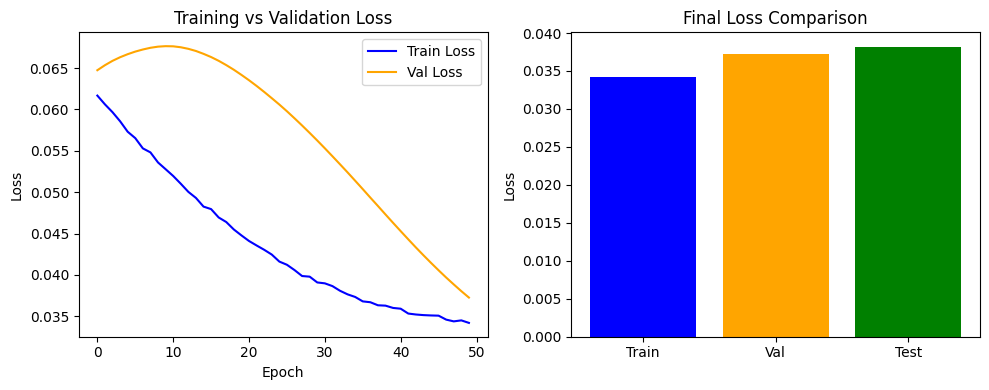


📊 MODEL FIT DIAGNOSIS:
   Train Loss: 0.0342
   Val Loss:   0.0373
   Test Loss:  0.0382

✅ Model looks WELL-GENERALIZED!


In [37]:
# ========================================
# STEP 9: Evaluate Model Fit
# ========================================
import matplotlib.pyplot as plt

# Calculate test loss
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_t)
    test_loss = loss_fn(test_predictions, y_test_t).item()

# Plot training curves
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.subplot(1, 2, 2)
bars = plt.bar(['Train', 'Val', 'Test'],
               [train_losses[-1], val_losses[-1], test_loss],
               color=['blue', 'orange', 'green'])
plt.ylabel('Loss')
plt.title('Final Loss Comparison')

plt.tight_layout()
plt.show()

# Diagnosis
print('\n📊 MODEL FIT DIAGNOSIS:')
print(f'   Train Loss: {train_losses[-1]:.4f}')
print(f'   Val Loss:   {val_losses[-1]:.4f}')
print(f'   Test Loss:  {test_loss:.4f}')

gap = val_losses[-1] - train_losses[-1]
if gap > 0.05:
    print('\n⚠️ Possible OVERFITTING - model memorized training data')
    print('   Try: more dropout, less epochs, or more data')
elif train_losses[-1] > 0.1:
    print('\n⚠️ Possible UNDERFITTING - model is too simple')
    print('   Try: more layers, more neurons, or more epochs')
else:
    print('\n✅ Model looks WELL-GENERALIZED!')

---
## 🎯 PART 4: Make Recommendations!

In [38]:
# ========================================
# STEP 10: Recommendation Function
# ========================================
"""
    Get movie recommendations for a user.

    Process:
    1. Get movies the user hasn't rated
    2. Compute features for each candidate
    3. Score with meta-learner
    4. Return top N
    """

def recommend_for_user(user_id, n_recommendations=10, exclude_movie_ids=None):
    """
    Get movie recommendations for a user.

    Args:
        user_id: The ID of the user to recommend for.
        n_recommendations: Number of recommendations to return.
        exclude_movie_ids: A set of MovieLens IDs to explicitly exclude from recommendations (e.g., movies already rated by the user in the training set).
    """
    if exclude_movie_ids is None:
        # Default exclusion: movies user already rated (global ratings)
        user_rated = set(ratings[ratings['userId'] == user_id]['movieId'].tolist())
    else:
        # Use provided exclusion set during evaluation
        user_rated = exclude_movie_ids

    scores = []

    for idx, row in movies.iterrows():
        movie_id = row['id']  # TMDB ID for feature computation
        movielens_id = row['movieId']  # MovieLens ID for evaluation

        if movielens_id in user_rated:
            continue

        # Compute features and score
        features = compute_features(user_id, movie_id)
        features_tensor = torch.tensor([features], dtype=torch.float32)

        with torch.no_grad():
            model.eval() # Ensure model is in evaluation mode
            score = model(features_tensor).item()

        # Return MovieLens ID (not TMDB ID) so it matches ground truth
        scores.append((row['title'], score, movielens_id))

    # Sort by score and return top N
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:n_recommendations]

# Test recommendations
test_user = 100

recommendations = recommend_for_user(test_user, n_recommendations=10)

print(f'\n🎬 Top 10 Recommendations for User {test_user}:')
print('-' * 50)

# For testing, we still exclude all previously rated movies for a clean recommendation list
recommendations = recommend_for_user(test_user, n_recommendations=10)
for i, (title, score, _) in enumerate(recommendations, 1):
    print(f'{i:2}. {title[:40]:<40} (score: {score:.3f})')


🎬 Top 10 Recommendations for User 100:
--------------------------------------------------
 1. You, Me and Dupree                       (score: 0.678)
 2. Live Flesh                               (score: 0.672)
 3. Greed                                    (score: 0.666)
 4. The Shawshank Redemption                 (score: 0.665)
 5. The Exorcism of Emily Rose               (score: 0.659)
 6. Shattered                                (score: 0.654)
 7. Blood Diamond                            (score: 0.652)
 8. Junebug                                  (score: 0.651)
 9. The Dark Knight                          (score: 0.650)
10. Pulp Fiction                             (score: 0.647)


---
## 📈 Visualize Evaluation Metrics

Evaluating 50 users with 5+ high-rated movies in our set


Evaluating: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


📊 RESULTS
@5: Precision=0.1440, Recall=0.2770, F1=0.1629, Hit Rate=0.5600, NDCG=0.3068, Accuracy=0.2957
@10: Precision=0.0940, Recall=0.3320, F1=0.1303, Hit Rate=0.6800, NDCG=0.3183, Accuracy=0.3354
@20: Precision=0.0700, Recall=0.4382, F1=0.1116, Hit Rate=0.8400, NDCG=0.3571, Accuracy=0.4382


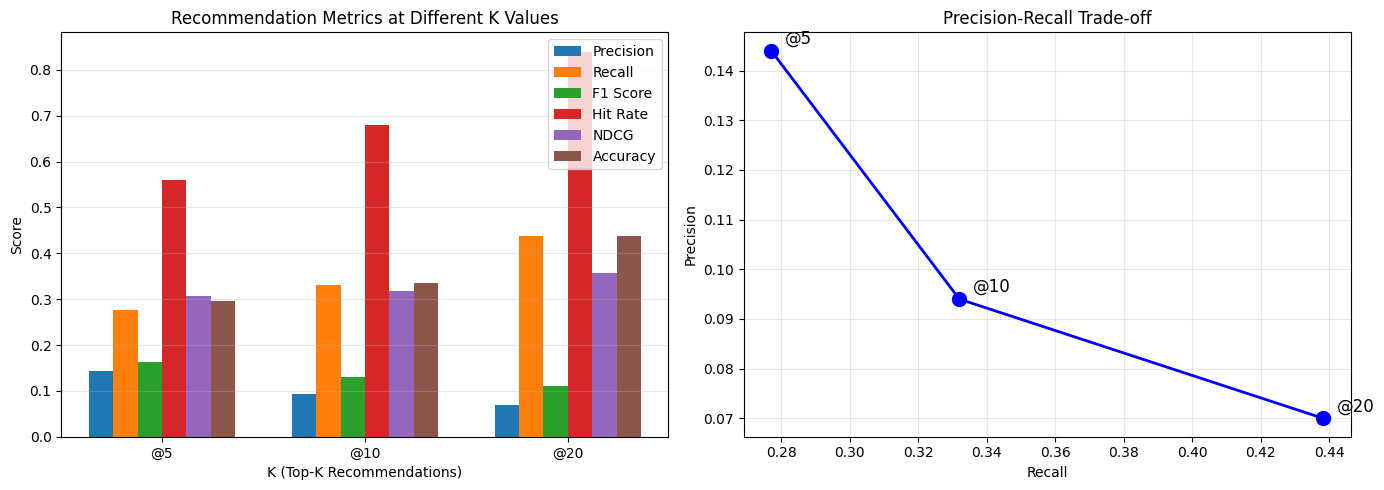


📊 AVERAGE EVALUATION RESULTS
@5: Precision=0.1440, Recall=0.2770, F1=0.1629, Hit Rate=0.5600, NDCG=0.3068, Accuracy=0.2957
@10: Precision=0.0940, Recall=0.3320, F1=0.1303, Hit Rate=0.6800, NDCG=0.3183, Accuracy=0.3354
@20: Precision=0.0700, Recall=0.4382, F1=0.1116, Hit Rate=0.8400, NDCG=0.3571, Accuracy=0.4382


In [43]:
def evaluate_properly(n_users=100, k_values=[5, 10, 20]):
    np.random.seed(42)  # Add this line at the start


    """Proper evaluation - temporarily hide test movies from user history."""
    global eval_results

    # Initialize eval_results with all metrics including accuracy
    eval_results = {k: {'precision': [], 'recall': [], 'f1': [], 'hit': [], 'ndcg': [], 'accuracy': []} for k in k_values}
    movies_set = set(movies['movieId'].values)

    # Get users with enough high ratings in our movie set
    user_high_ratings = ratings[(ratings['rating'] >= 4.0) &
                                 (ratings['movieId'].isin(movies_set))].groupby('userId')['movieId'].apply(list).to_dict()

    valid_users = [u for u, m in user_high_ratings.items() if len(m) >= 5]
    sample_users = np.random.choice(valid_users, size=min(n_users, len(valid_users)), replace=False)

    print(f'Evaluating {len(sample_users)} users with 5+ high-rated movies in our set')

    for user_id in tqdm(sample_users, desc='Evaluating'):
        user_high = user_high_ratings[user_id]

        # Hold out 20% as test
        np.random.shuffle(user_high)
        n_test = max(1, len(user_high) // 5)
        test_movies = set(user_high[:n_test])

        # Get movies user rated (excluding test set)
        all_rated = set(ratings[ratings['userId'] == user_id]['movieId'].tolist())
        train_rated = all_rated - test_movies

        # Score all candidate movies
        scores = []
        for idx, row in movies.iterrows():
            mid = row['movieId']
            if mid in train_rated:
                continue
            features = compute_features(user_id, row['id'])
            features_tensor = torch.tensor([features], dtype=torch.float32)
            with torch.no_grad():
                score = model(features_tensor).item()
            scores.append((mid, score))

        scores.sort(key=lambda x: x[1], reverse=True)
        rec_ids = [s[0] for s in scores[:max(k_values)]]

        for k in k_values:
            top_k = set(rec_ids[:k])
            hits = len(top_k & test_movies)

            # Precision
            precision = hits / k if k > 0 else 0
            eval_results[k]['precision'].append(precision)

            # Recall
            recall = hits / len(test_movies) if len(test_movies) > 0 else 0
            eval_results[k]['recall'].append(recall)

            # F1 Score
            if precision + recall > 0:
                f1 = 2 * (precision * recall) / (precision + recall)
            else:
                f1 = 0
            eval_results[k]['f1'].append(f1)

            # Hit Rate
            eval_results[k]['hit'].append(1 if hits > 0 else 0)

            # Accuracy
            accuracy = hits / min(k, len(test_movies)) if min(k, len(test_movies)) > 0 else 0
            eval_results[k]['accuracy'].append(accuracy)

            # NDCG
            ndcg = 0
            if hits > 0 and len(test_movies) > 0:
                for rank, rec_id in enumerate(rec_ids[:k]):
                    if rec_id in test_movies:
                        ndcg += 1 / np.log2(rank + 2)
                ideal_dcg = sum(1 / np.log2(i + 2) for i in range(min(len(test_movies), k)))
                if ideal_dcg > 0:
                    ndcg /= ideal_dcg
            eval_results[k]['ndcg'].append(ndcg)

    print('='*60)
    print('📊 RESULTS')
    print('='*60)
    for k in k_values:
        print(f"@{k}: Precision={np.mean(eval_results[k]['precision']):.4f}, "
              f"Recall={np.mean(eval_results[k]['recall']):.4f}, "
              f"F1={np.mean(eval_results[k]['f1']):.4f}, "
              f"Hit Rate={np.mean(eval_results[k]['hit']):.4f}, "
              f"NDCG={np.mean(eval_results[k]['ndcg']):.4f}, "
              f"Accuracy={np.mean(eval_results[k]['accuracy']):.4f}")

evaluate_properly(n_users=50)

# ========================================
# Plotting
# ========================================
import matplotlib.pyplot as plt

k_values = [5, 10, 20]
metrics = ['precision', 'recall', 'f1', 'hit', 'ndcg', 'accuracy']
metric_labels = ['Precision', 'Recall', 'F1 Score', 'Hit Rate', 'NDCG', 'Accuracy']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Metrics by K
ax1 = axes[0]
x = np.arange(len(k_values))
width = 0.12
for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
    values = [np.mean(eval_results[k][metric]) for k in k_values]
    ax1.bar(x + i*width, values, width, label=label)

ax1.set_xlabel('K (Top-K Recommendations)')
ax1.set_ylabel('Score')
ax1.set_title('Recommendation Metrics at Different K Values')
ax1.set_xticks(x + width * 2.5)
ax1.set_xticklabels([f'@{k}' for k in k_values])
ax1.legend(loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Precision-Recall Trade-off
ax2 = axes[1]
precisions = [np.mean(eval_results[k]['precision']) for k in k_values]
recalls = [np.mean(eval_results[k]['recall']) for k in k_values]

ax2.plot(recalls, precisions, 'bo-', markersize=10, linewidth=2)
for i, k in enumerate(k_values):
    ax2.annotate(f'@{k}', (recalls[i], precisions[i]),
                 textcoords='offset points', xytext=(10, 5), fontsize=12)

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Trade-off')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print('\n' + '='*60)
print('📊 AVERAGE EVALUATION RESULTS')
print('='*60)
for k in k_values:
    print(f"@{k}: Precision={np.mean(eval_results[k]['precision']):.4f}, "
          f"Recall={np.mean(eval_results[k]['recall']):.4f}, "
          f"F1={np.mean(eval_results[k]['f1']):.4f}, "
          f"Hit Rate={np.mean(eval_results[k]['hit']):.4f}, "
          f"NDCG={np.mean(eval_results[k]['ndcg']):.4f}, "
          f"Accuracy={np.mean(eval_results[k]['accuracy']):.4f}")


In [ ]:
# Debug check
print(f"Movies count: {len(movies)}")
print(f"movie_id_to_idx size: {len(movie_id_to_idx)}")
print(f"movieId_to_idx size: {len(movieId_to_idx)}")
print(f"movie_embeddings shape: {movie_embeddings.shape}")
print(f"User profiles count: {len(user_profiles)}")

# Check if user profiles are being built correctly
test_user = list(user_profiles.keys())[0] if user_profiles else None
print(f"Sample user profile exists: {test_user is not None}")


Movies count: 576
movie_id_to_idx size: 575
movieId_to_idx size: 575
movie_embeddings shape: (576, 384)
User profiles count: 663
Sample user profile exists: True


In [46]:
# ========================================
# SAVE MODEL AND DATA FOR STREAMLIT
# ========================================
import pickle
import torch # Add this import statement

# Save the trained PyTorch model
torch.save(model.state_dict(), 'meta_learner_weights.pt')

# Save embeddings
np.save('movie_embeddings.npy', movie_embeddings)

# Save dataframes
movies.to_csv('movies_filtered.csv', index=False)
ratings.to_csv('ratings_filtered.csv', index=False)

# Save all mappings and user data
mappings = {
    'user_to_idx': user_to_idx,
    'movie_to_idx': movie_to_idx,
    'movie_id_to_idx': movie_id_to_idx,
    'movieId_to_idx': movieId_to_idx,
    'user_profiles': user_profiles,
    'user_genre_prefs': user_genre_prefs,
    'all_genres': all_genres
}

with open('mappings.pkl', 'wb') as f:
    pickle.dump(mappings, f)

# Save ALS model factors
# Convert to numpy arrays before saving
np.save('als_user_factors.npy', als_model.user_factors.to_numpy())
np.save('als_item_factors.npy', als_model.item_factors.to_numpy())

print('✅ All files saved!')
print('Files created:')
print('  - meta_learner_weights.pt')
print('  - movie_embeddings.npy')
print('  - movies_filtered.csv')
print('  - ratings_filtered.csv')
print('  - mappings.pkl')
print('  - als_user_factors.npy')
print('  - als_item_factors.npy')

✅ All files saved!
Files created:
  - meta_learner_weights.pt
  - movie_embeddings.npy
  - movies_filtered.csv
  - ratings_filtered.csv
  - mappings.pkl
  - als_user_factors.npy
  - als_item_factors.npy
